In [1]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from PIL import Image
from xml.etree import ElementTree as ET
from tqdm import tqdm

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annotations = self.load_annotations()

    def __getitem__(self, idx):
        # Load image and annotations
        img_path = os.path.join(self.root, 
                                'sfrs_' + self.annotations[idx]['filename'][2], 
                                self.annotations[idx]['filename'][:-7], 
                                self.annotations[idx]['filename'])
        
        img = Image.open(img_path).convert("L")
        target = self.annotations[idx]['annotation']
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target

    def __len__(self):
        return len(self.annotations)

    def load_annotations(self):
        annotations = []
        # Parse XML files
        for root, dirs, files in os.walk(self.root):
            for xml_file in files:
                if xml_file.endswith(".xml"):
                    tree = ET.parse(os.path.join(root, xml_file))
                    root = tree.getroot()
                    annotation = {
                        'filename': root.find('filename').text,
                        'annotation': {
                            'boxes': [],
                            'labels': []
                        }
                    }
                    for obj in root.findall('object'):
                        box = obj.find('bndbox')
                        xmin = int(box.find('xmin').text)
                        ymin = int(box.find('ymin').text)
                        xmax = int(box.find('xmax').text)
                        ymax = int(box.find('ymax').text)

                        annotation['annotation']['boxes'].append([xmin, ymin, xmax, ymax])
                        annotation['annotation']['labels'].append(int(obj.find('name').text))

                    annotations.append(annotation)

        return annotations

In [3]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = CustomDataset(root='../data/data', transforms=transform)

In [4]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [5]:
# NOTE THAT I AM USING THIS TO SPEED UP THE DEV
sampler = torch.utils.data.RandomSampler(train_dataset, replacement=True, num_samples=6)

In [6]:
# Define data loaders
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                           shuffle=True,
                            num_workers=0,
                            # sampler=sampler
                          )
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False,num_workers=0)

In [7]:
# Load a pre-trained Faster R-CNN model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [8]:
# Define the optimizer and the learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [9]:
# Define the training loop
def training_loop(num_epochs, batch_size): 
    model.train()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    for epoch in range(num_epochs):
        total_batches = len(train_loader)
        with tqdm(total=total_batches, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for batch_idx, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                targets = []
                for i in range(batch_size):
                    d = {}
                    d['boxes'] = torch.tensor([b[i] for b in labels['boxes'][0]]).unsqueeze(0).to(device)
                    d['labels'] = torch.tensor([labels['labels'][0][i]]).to(device)
                    targets.append(d)
                output = model(images, targets)
                losses = sum(loss for loss in output.values())
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                # Update the progress bar
                pbar.update(1)

        # Update the learning rate
        lr_scheduler.step()

    torch.save(model, '../models/findbox.pth')

In [10]:
# Run the training
training_loop(10, batch_size=batch_size)

Epoch 10/10: 100%|████████████████████████████████████████████████████████████████| 180/180 [01:43<00:00,  1.75batch/s]


In [11]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15,15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0,i].imshow(np.asarray(img))
        axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

tensor([0.9982], device='cuda:0')


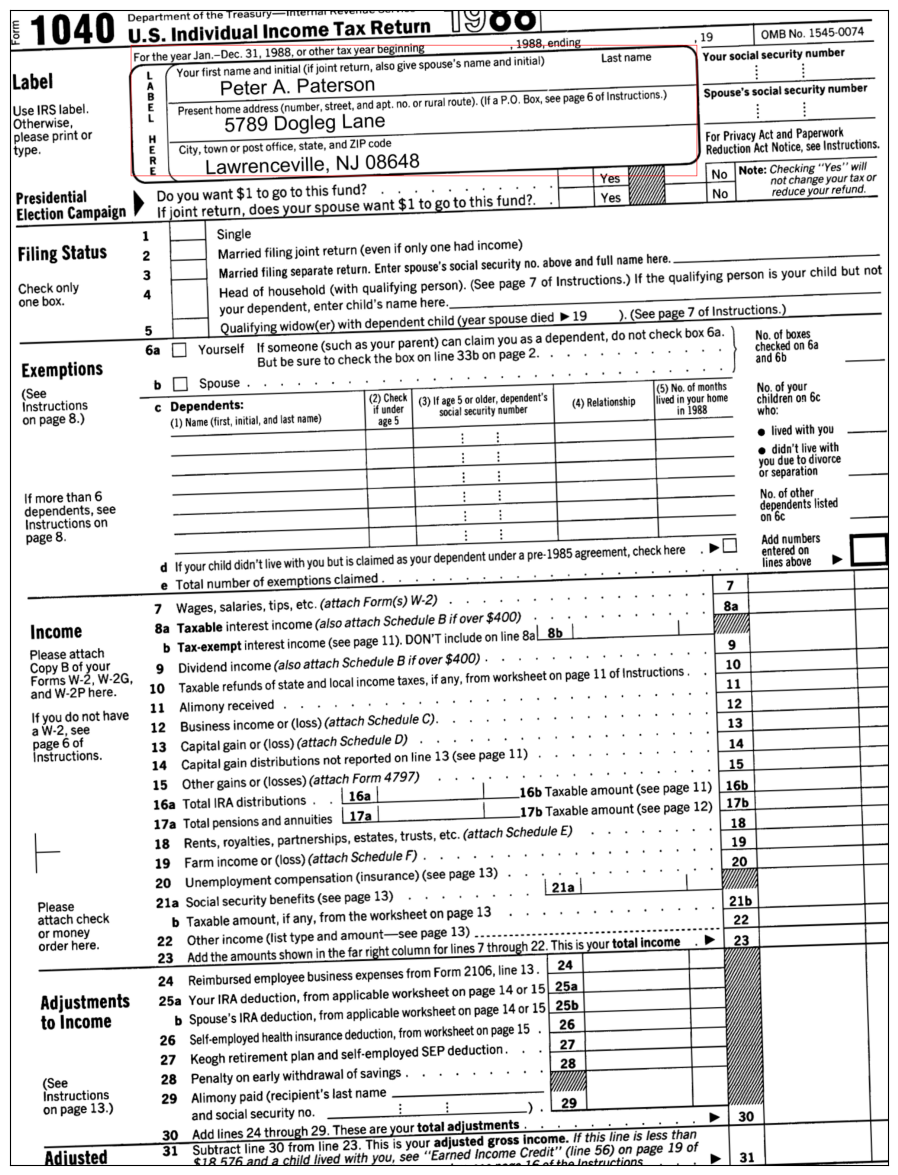

In [12]:
# define a function to test a new image
def test_model(img_path):
    model = torch.load('../models/findbox.pth')
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.eval()
    original_img = Image.open(img_path).convert("L")
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    img = transform(original_img).unsqueeze(0).to(device)
    output = model(img)
    boxes = output[0]['boxes'].detach().to(device)
    labels = output[0]['labels'].detach().to(device)
    scores = output[0]['scores'].detach().to(device)

    # find the box with the highest condifence score
    max_score_idx = torch.argmax(scores)
    boxes = boxes[max_score_idx].unsqueeze(0)
    scores = scores[max_score_idx].unsqueeze(0)

    # Convert image into Tensor of shape (C x H x W) and dtype uint8
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    img_tensor = transform(original_img)
    output_image = draw_bounding_boxes(image=img_tensor, boxes=boxes, colors=(255, 0, 0))
    print(scores)
    show(output_image)

    return boxes, scores

result_box = test_model('../data/test_form_tilted.png')



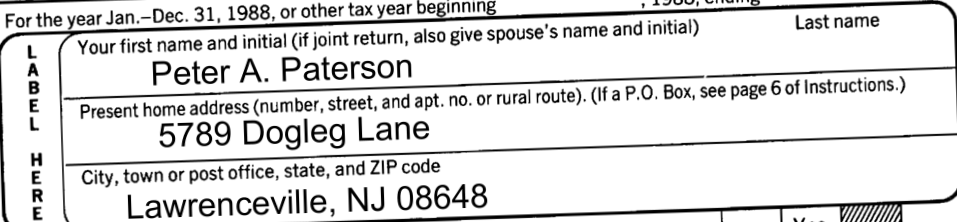

In [13]:
def cropImage(img_path, box):
    img = Image.open(img_path).convert("L")
    box = tuple(box[0].tolist())
    img = img.crop(box)
    img.save('../data/cropped.png')
    display(img)

cropped_img = cropImage("../data/test_form_tilted.png", result_box[0])

In [14]:
import easyocr
reader = easyocr.Reader(['en'])
result = reader.readtext('../data/cropped.png')

In [15]:
for text in result:
    print(text)

([[2, 0], [274, 0], [274, 32], [2, 32]], 'For the year Jan~Dec 31,1988', 0.4331400140177445)
([[278, 0], [500, 0], [500, 22], [278, 22]], 'or other tax year beginning', 0.9321653968004429)
([[792, 10], [884, 10], [884, 34], [792, 34]], 'Last name', 0.990033413114347)
([[114, 12], [704, 12], [704, 60], [114, 60]], "dirst name and initial (f joint return, also give spouse' $ name and initial)", 0.5840936013777234)
([[75, 37], [119, 37], [119, 57], [75, 57]], 'Your', 0.9999391436576843)
([[27, 61], [43, 61], [43, 115], [27, 115]], '1', 0.2717830412607647)
([[148, 46], [420, 46], [420, 94], [148, 94]], 'Peter A Paterson_', 0.8735613168906022)
([[491, 73], [909, 73], [909, 109], [491, 109]], 'rural route). (If a P.O. Box, see page 6 of Instructions )', 0.6264296932836474)
([[76, 92], [378, 92], [378, 124], [76, 124]], 'Present home address (number, street,', 0.7049947114452967)
([[410, 90], [496, 90], [496, 114], [410, 114]], 'apt: no: or', 0.3855214699755348)
([[155, 113], [435, 113], [435